In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

#load np arrays 
data = np.load('data/egamma_norm.npz', mmap_mode='r')

#split into train (90%) /valid (10%) set and save
seed = 123
X_train, X_valid, y_train, y_valid = train_test_split(data['X_train'], data['y_train'], test_size=0.1, stratify=data['y_train'], random_state=seed)

train_x, train_y = X_train, y_train
valid_x, valid_y = X_valid, y_valid
test_x, test_y = data['X_test'], data['y_test']

In [2]:
class Net(tf.keras.Model):

    def __init__(self, skip_connection=False):
        super().__init__()
        
        self.skip_connection = skip_connection
        
        self.rflip = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.conv1p1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same')
        self.maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
        self.conv2p1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same')
        self.maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
        self.conv3p1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same')
        self.maxpool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        
        self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding='same', activation='relu')
        
        self.gloavgpool = tf.keras.layers.GlobalAveragePooling2D()
        
        self.dense1 = tf.keras.layers.Dense(1, activation='sigmoid')
        self.dropout1 = tf.keras.layers.Dropout(.1)
    
    def build_graph(self):
        x = tf.keras.layers.Input(shape=train_x.shape[1:])
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

    def call(self, inputs):
        x = self.rflip(inputs)
        
        x_res = self.conv1(x)
        x = self.conv1p1(x_res)
        if self.skip_connection: x = x+x_res
        x = self.maxpool1(x)
        x = self.batchnorm1(tf.keras.layers.ReLU()(x))
        
        x_res = self.conv2(x)
        x = self.conv2p1(x_res)
        if self.skip_connection: x = x+x_res
        x = self.maxpool2(x)
        x = self.batchnorm2(tf.keras.layers.ReLU()(x))
        
        x_res = self.conv3(x)
        x = self.conv3p1(x_res)
        if self.skip_connection: x = x+x_res
        x = self.maxpool3(x)
        x = self.batchnorm3(tf.keras.layers.ReLU()(x))
        
        x = self.conv4(x)
        
        x = self.dropout1(self.gloavgpool(x))
        
        return self.dense1(x)

In [3]:
model = Net()
model.build_graph().summary()

2023-03-15 10:28:18.040766: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 10:28:18.789813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21313 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:2f:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 16, 16, 64)        0         
                                                             

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                    tf.keras.metrics.AUC(name='auc')])

In [5]:
print("Num of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num of GPUs Available:  1


In [6]:
import sys
import pickle

# log_dir = "logs/runs"
# summary_writer = tf.summary.create_file_writer(log_dir)

# log_dir = "runs" 
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=2, mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='models/task1_model_keras.ckpt')

metric_logger = {}
for label in ['Train', 'Test', 'Valid', 'Trainb']:
    metric_logger['Accuracy/'+label] = []
    metric_logger['AUC/'+label] = []
    metric_logger['Loss/'+label] = []

class logging(tf.keras.callbacks.Callback):
    def __init__(self, x, y, label='Test'):
        self.x, self.y = x, y
        self.label = label

    def on_epoch_end(self, epoch, logs={}):
        
        metrics = self.model.evaluate(self.x, self.y, batch_size=None, verbose=False)

        print('\nEpoch {} {} set: Avg. loss: {:.4f}, Accuracy: {:.4f}, AUC :{:.4f}\n'.format(
            epoch,
            self.label,
            metrics[0], 
            metrics[1],
            metrics[2]))
        
        metric_logger['Loss/'+self.label].append(metrics[0])
        metric_logger['Accuracy/'+self.label].append(metrics[1])
        metric_logger['AUC/'+self.label].append(metrics[2])
        
        with open('logs/metrics.pickle', 'wb') as handle:
            pickle.dump(metric_logger, handle)
        
#         with summary_writer.as_default():
#             tf.summary.scalar('Loss/'+self.label, metrics[0], step=epoch)
#             tf.summary.scalar('Accuracy/'+self.label, metrics[1], step=epoch)
#             tf.summary.scalar('AUC/'+self.label, metrics[2], step=epoch)

        sys.stdout.flush()

In [ ]:
sys.stdout = open("logs/my_log_keras.txt", "a")
history = model.fit(x=train_x, y=train_y, batch_size=32, epochs=100, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint, logging(train_x, train_y, 'Train'), logging(valid_x, valid_y, 'Valid'), logging(test_x, test_y), reduce_lr, early_stopping])

2023-03-15 10:28:27.134992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-03-15 10:30:54.048829: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/task1_model_keras.ckpt/assets
INFO:tensorflow:Assets written to: models/task1_model_keras.ckpt/assets
INFO:tensorflow:Assets written to: models/task1_model_keras.ckpt/assets


In [1]:
!cat logs/my_log_keras.txt

Epoch 1/100


11193/11193 [==============================] - ETA: 0s - loss: 0.5987 - binary_accuracy: 0.6843 - auc: 0.7403
Epoch 0 Train set: Avg. loss: 0.6531, Accuracy: 0.6302, AUC :0.7632


Epoch 0 Valid set: Avg. loss: 0.6530, Accuracy: 0.6289, AUC :0.7631


Epoch 0 Test set: Avg. loss: 0.6536, Accuracy: 0.6300, AUC :0.7623

11193/11193 [==============================] - 234s 21ms/step - loss: 0.5987 - binary_accuracy: 0.6843 - auc: 0.7403 - val_loss: 0.6530 - val_binary_accuracy: 0.6289 - val_auc: 0.7631 - lr: 0.0010
Epoch 2/100


11191/11193 [============================>.] - ETA: 0s - loss: 0.5670 - binary_accuracy: 0.7147 - auc: 0.7769
Epoch 1 Train set: Avg. loss: 0.5784, Accuracy: 0.7031, AUC :0.7834


Epoch 1 Valid set: Avg. loss: 0.5766, Accuracy: 0.7054, AUC :0.7854


Epoch 1 Test set: Avg. loss: 0.5794, Accuracy: 0.7026, AUC :0.7824

11193/11193 [==============================] - 235s 21ms/step - loss: 0.5670 - binary_accuracy: 0.7147 - auc: 0.7769 - val_loss: 0.5766 - val_binary_accuracy: 0.7054 - val_auc: 0.7854 - lr: 0.0010
Epoch 3/100


11099/11193 [============================>.] - ETA: 1s - loss: 0.5597 - binary_accuracy: 0.7205 - auc: 0.7843

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11191/11193 [============================>.] - ETA: 0s - loss: 0.5149 - binary_accuracy: 0.7503 - auc: 0.8240
Epoch 34 Train set: Avg. loss: 0.5120, Accuracy: 0.7526, AUC :0.8262


Epoch 34 Valid set: Avg. loss: 0.5275, Accuracy: 0.7439, AUC :0.8142


Epoch 34 Test set: Avg. loss: 0.5303, Accuracy: 0.7399, AUC :0.8117

11193/11193 [==============================] - 220s 20ms/step - loss: 0.5150 - binary_accuracy: 0.7503 - auc: 0.8240 - val_loss: 0.5275 - val_binary_accuracy: 0.7439 - val_auc: 0.8142 - lr: 1.5625e-05
Epoch 36/100


 9635/11193 [========================>.....] - ETA: 17s - loss: 0.5151 - binary_accuracy: 0.7507 - auc: 0.8238

11191/11193 [============================>.] - ETA: 0s - loss: 0.5149 - binary_accuracy: 0.7511 - auc: 0.8240
Epoch 35 Train set: Avg. loss: 0.5119, Accuracy: 0.7525, AUC :0.8263


Epoch 35 Valid set: Avg. loss: 0.5275, Accuracy: 0.7438, AUC :0.8142


Epoch 35 Test set: Avg. loss: 0.5302, Accuracy: 0.7398, AUC :0.8117

11193/11193 [==============================] - 224s 20ms/step - loss: 0.5149 - binary_accuracy: 0.7511 - auc: 0.8240 - val_loss: 0.5275 - val_binary_accuracy: 0.7438 - val_auc: 0.8142 - lr: 1.5625e-05
Epoch 37/100


10542/11193 [===========================>..] - ETA: 7s - loss: 0.5147 - binary_accuracy: 0.7513 - auc: 0.8241

11192/11193 [============================>.] - ETA: 0s - loss: 0.5148 - binary_accuracy: 0.7512 - auc: 0.8241
Epoch 36 Train set: Avg. loss: 0.5118, Accuracy: 0.7527, AUC :0.8264


Epoch 36 Valid set: Avg. loss: 0.5274, Accuracy: 0.7439, AUC :0.8141


Epoch 36 Test set: Avg. loss: 0.5301, Accuracy: 0.7401, AUC :0.8117

11193/11193 [==============================] - 223s 20ms/step - loss: 0.5148 - binary_accuracy: 0.7513 - auc: 0.8241 - val_loss: 0.5274 - val_binary_accuracy: 0.7439 - val_auc: 0.8141 - lr: 7.8125e-06
Epoch 38/100


11191/11193 [============================>.] - ETA: 0s - loss: 0.5145 - binary_accuracy: 0.7511 - auc: 0.8243
Epoch 37 Train set: Avg. loss: 0.5118, Accuracy: 0.7528, AUC :0.8265


Epoch 37 Valid set: Avg. loss: 0.5274, Accuracy: 0.7437, AUC :0.8142


Epoch 37 Test set: Avg. loss: 0.5300, Accuracy: 0.7402, AUC :0.8118

11193/11193 [==============================] - 226s 20ms/step - loss: 0.5145 - binary_accuracy: 0.7511 - auc: 0.8243 - val_loss: 0.5274 - val_binary_accuracy: 0.7437 - val_auc: 0.8142 - lr: 7.8125e-06
Epoch 39/100


 6156/11193 [===============>..............] - ETA: 57s - loss: 0.5141 - binary_accuracy: 0.7518 - auc: 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



AUC
Number of Epochs 47: Testing 0.8117, Training 0.8266, Valid 0.8142
Accuracy
Number of Epochs 47: Testing 0.7402, Training 0.7529, Valid 0.7438
Loss
Number of Epochs 47: Testing 0.5302, Training 0.5115, Valid 0.5275
Best Test AUC achieved at Epoch 40: 0.8118
Test AUC achieved at last Epoch: 0.8117


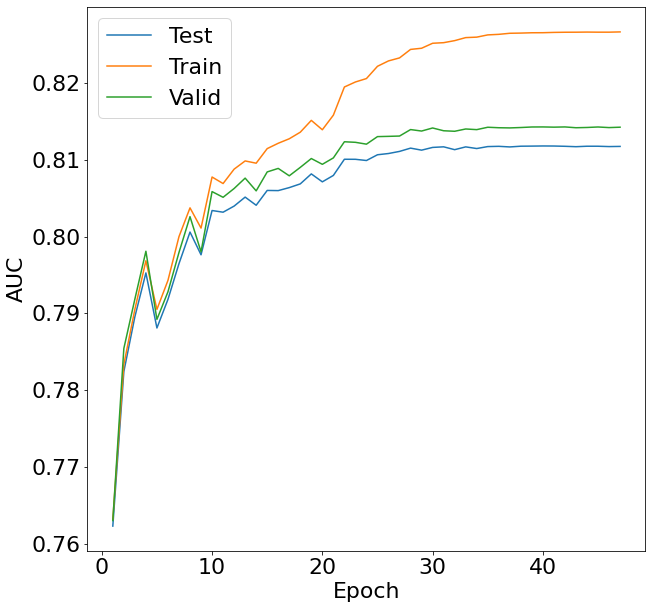

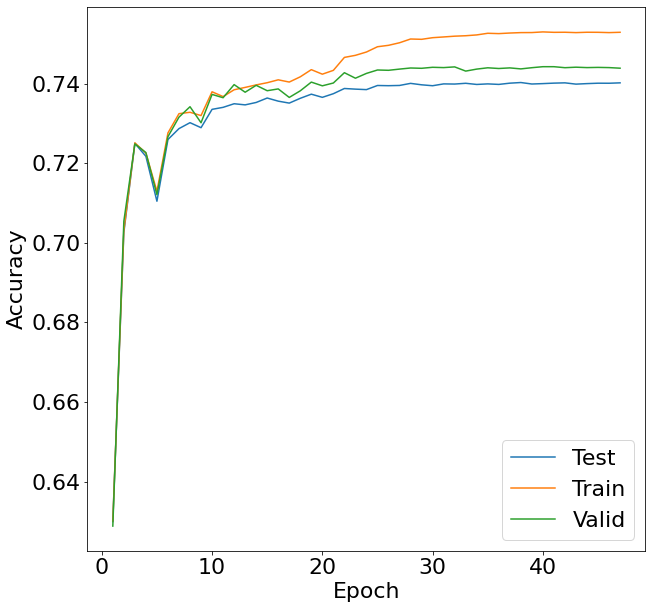

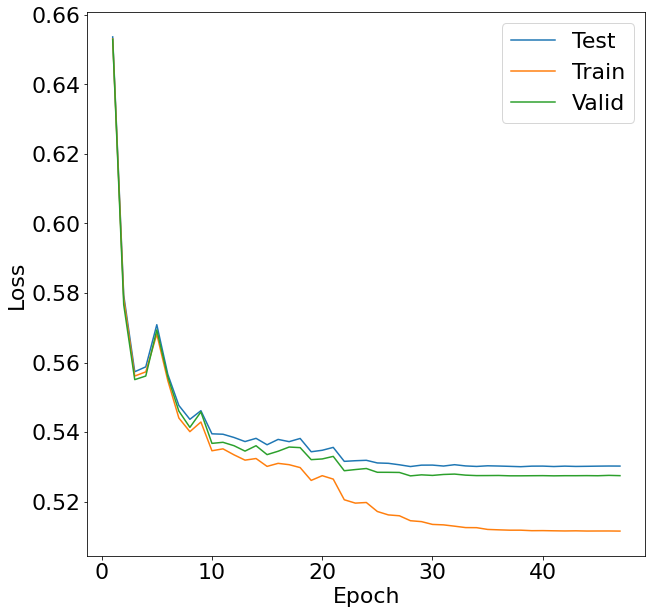

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open('logs/metrics.pickle', 'rb') as handle:
    metric_logger = pickle.load(handle)

#Plot training/valid/testing metrics
for metric in set([_.split('/')[0] for _ in metric_logger.keys()]):
    plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 22})
    epochs = len(metric_logger[metric+'/Test'])
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Test'], label='Test')
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Train'], label='Train')
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Valid'], label='Valid')
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    print(metric)
    print('Number of Epochs {}: Testing {:.4f}, Training {:.4f}, Valid {:.4f}'.format(epochs, metric_logger[metric+'/Test'][-1], metric_logger[metric+'/Train'][-1], metric_logger[metric+'/Valid'][-1]))
    
print('Best Test AUC achieved at Epoch {}: {:.4f}'.format(np.argmax(metric_logger['AUC/Test'])+1, max(metric_logger['AUC/Test'])))
print('Test AUC achieved at last Epoch: {:.4f}'.format(metric_logger['AUC/Test'][-1]))